In [1]:
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATASET = "E:/EuroSAT/2750"

LABELS = os.listdir(DATASET)
print(LABELS)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


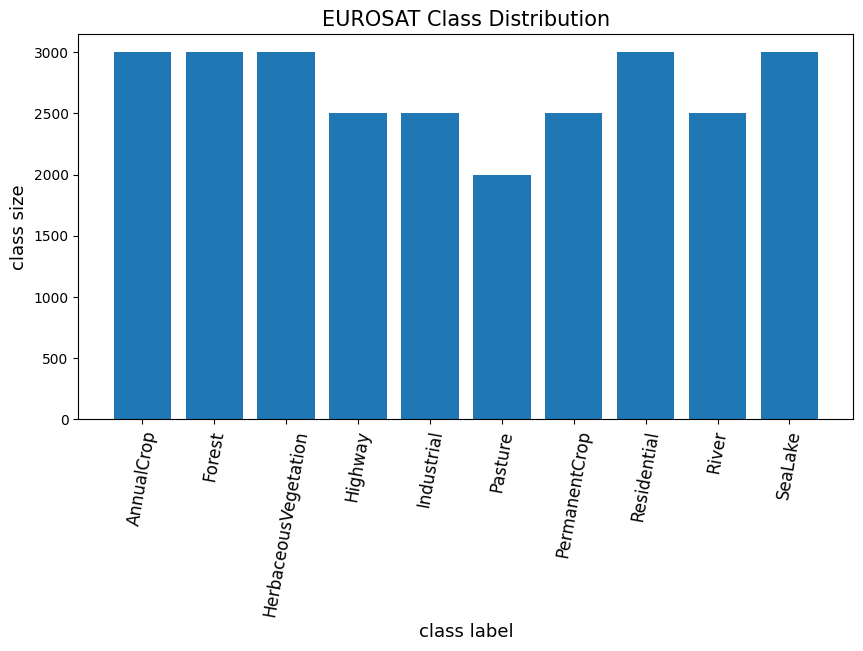

In [3]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

    
plt.figure(figsize=(10, 5))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=80)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

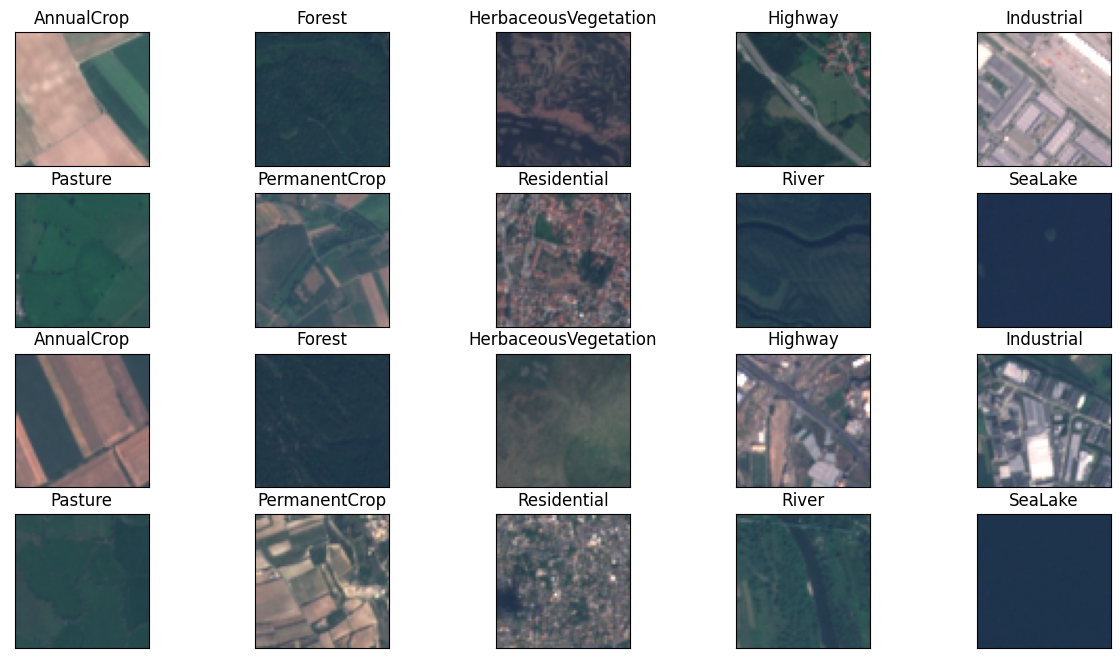

In [4]:
img_paths = [os.path.join(DATASET, l, l+'_1000.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(DATASET, l, l+'_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('\\')[1])

plot_sat_imgs(img_paths)

In [5]:
from skimage import io

def plot_img_histogram(img_path):
    
    image = io.imread(img_path)
    plt.hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
    plt.hist(image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
    plt.hist(image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
    plt.xlabel('Intensity')
    plt.ylabel('Count')
    plt.title(img_path.split('\\')[1])
    plt.show()

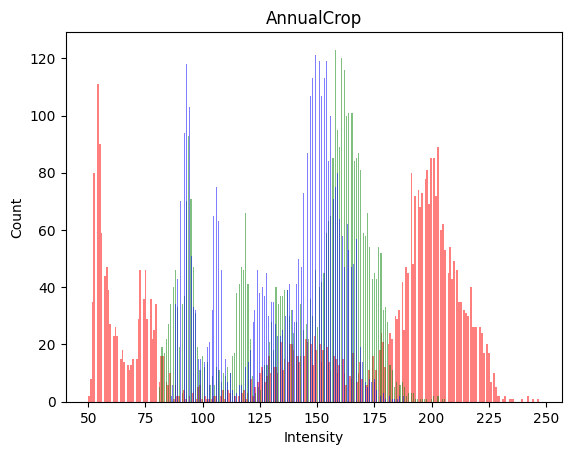

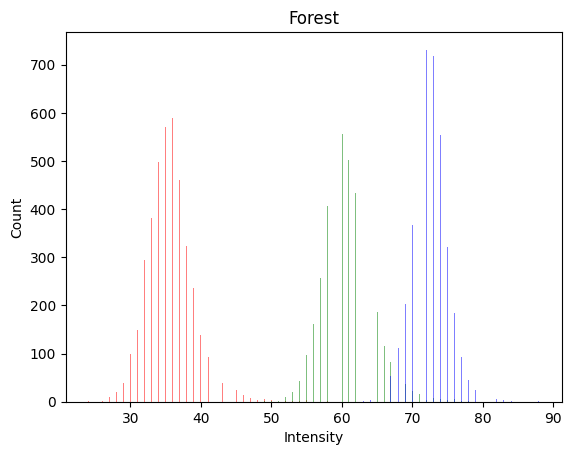

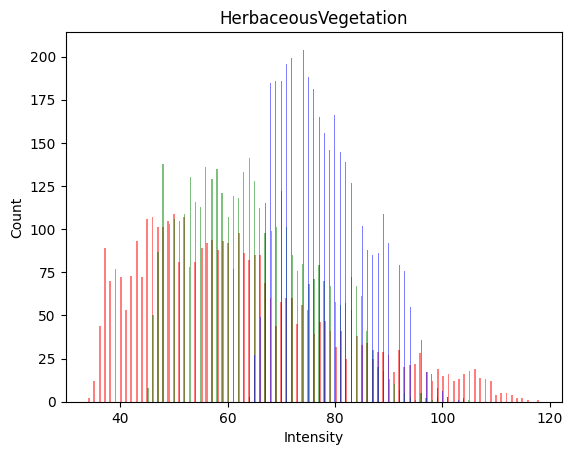

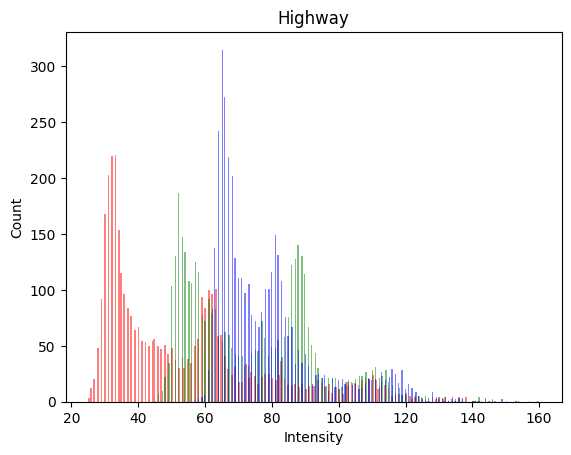

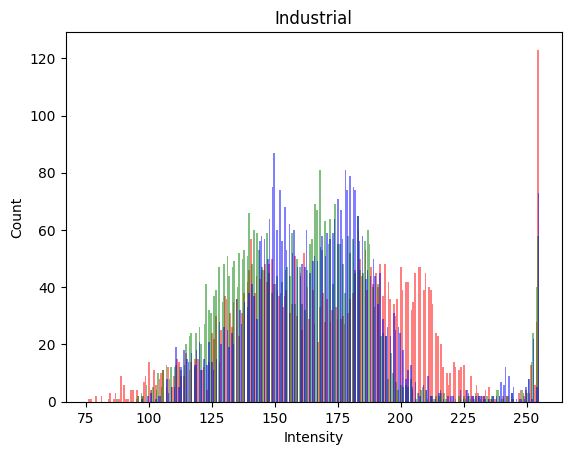

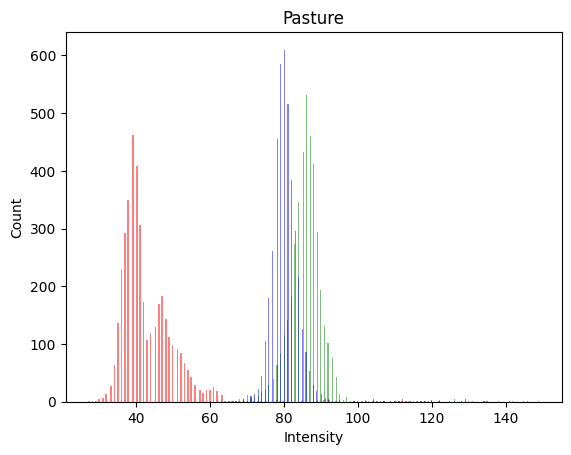

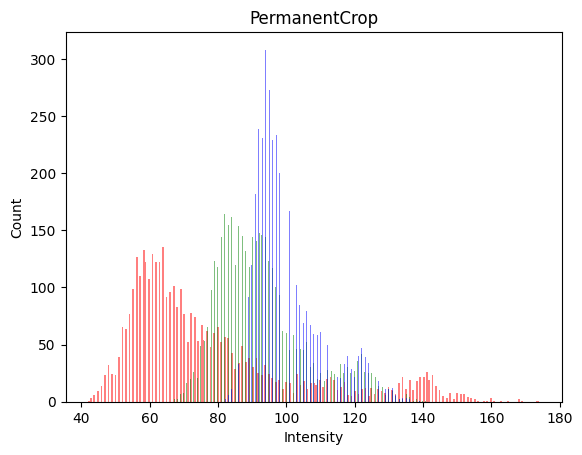

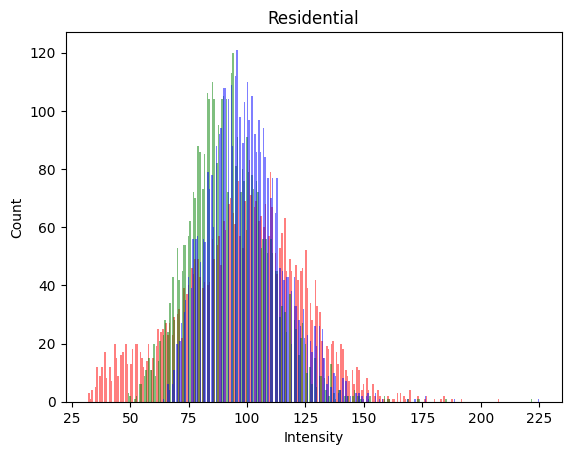

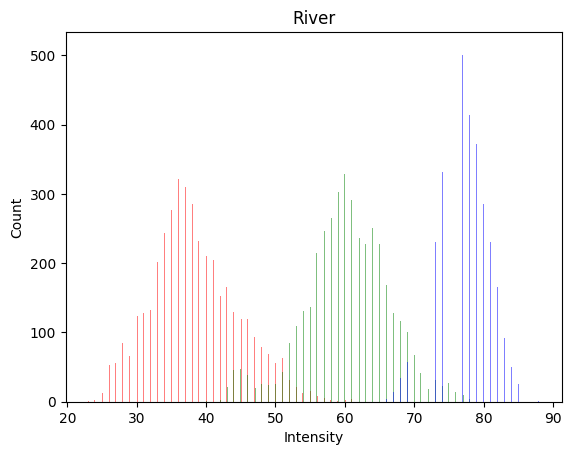

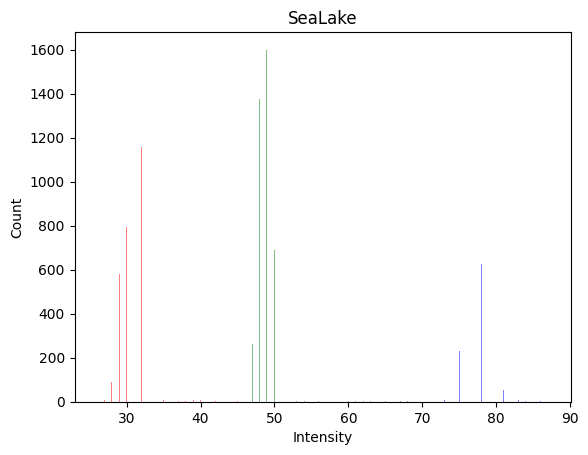

In [6]:
for l in LABELS:
   path = os.path.join(DATASET, l, l+'_1000.jpg')
   plot_img_histogram(path)

In [7]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = 'E:\\EuroSAT\\working\\training'
TEST_DIR = 'E:\\EuroSAT\\working\\testing'
BATCH_SIZE = 128
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

In [8]:
# map each image path to their class label in 'data'
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
        data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=69)

# split the list of image paths
for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub('E:/EuroSAT/2750', 'E:/EuroSAT/working/training', i) for i in train_paths]
    new_test_paths = [re.sub('E:/EuroSAT/2750', 'E:/EuroSAT/working/testing', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])
    
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

moving training files..


100%|██████████| 18900/18900 [00:00<00:00, 64944.06it/s]


moving testing files..


100%|██████████| 8100/8100 [00:29<00:00, 272.06it/s]  


In [9]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.3
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)

valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',    
    color_mode='rgb',
    shuffle=True,
    seed=69
)

# test generator for evaluation purposes - no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 15120 images belonging to 10 classes.
Found 6480 images belonging to 10 classes.
Found 8100 images belonging to 10 classes.


In [10]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [11]:
np.save('class_indices', train_generator.class_indices)

In [13]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adagrad


from keras.applications.vgg16 import VGG16


from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score

In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

1 Physical GPUs, 1 Logical GPU


In [15]:
def compile_model(input_shape, n_classes, optimizer, fine_tune=None):
    
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape,
                     pooling='avg')
    
    top_model = conv_base.output
    top_model = Dense(2048, activation='relu')(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
        
    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    
    return model

def plot_history(history):
       
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    print(f"Global F2 Score: {f2}")    
    return results, conf_mat

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))    

In [16]:
optim = Adagrad()

model = compile_model(INPUT_SHAPE, NUM_CLASSES, optim, fine_tune=None)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [17]:
N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = valid_generator.samples//BATCH_SIZE
N_EPOCHS = 100

    # model callbacks
checkpoint = ModelCheckpoint(filepath='E:/EuroSAT/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

In [18]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint],
                             validation_data=valid_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100


d:\anaconda3\envs\pastis\lib\site-packages\ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


118/118 [==============================] - ETA: 0s - loss: 2.1157 - categorical_accuracy: 0.3424
Epoch 1: val_categorical_accuracy improved from -inf to 0.42578, saving model to E:/EuroSAT/working\model.weights.best.hdf5
118/118 [==============================] - 24s 190ms/step - loss: 2.1157 - categorical_accuracy: 0.3424 - val_loss: 1.9870 - val_categorical_accuracy: 0.4258
Epoch 2/100
118/118 [==============================] - ETA: 0s - loss: 1.8981 - categorical_accuracy: 0.4422
Epoch 2: val_categorical_accuracy improved from 0.42578 to 0.42797, saving model to E:/EuroSAT/working\model.weights.best.hdf5
118/118 [==============================] - 21s 178ms/step - loss: 1.8981 - categorical_accuracy: 0.4422 - val_loss: 1.8266 - val_categorical_accuracy: 0.4280
Epoch 3/100
118/118 [==============================] - ETA: 0s - loss: 1.7642 - categorical_accuracy: 0.4668
Epoch 3: val_categorical_accuracy improved from 0.42797 to 0.45609, saving model to E:/EuroSAT/working\model.weights.b

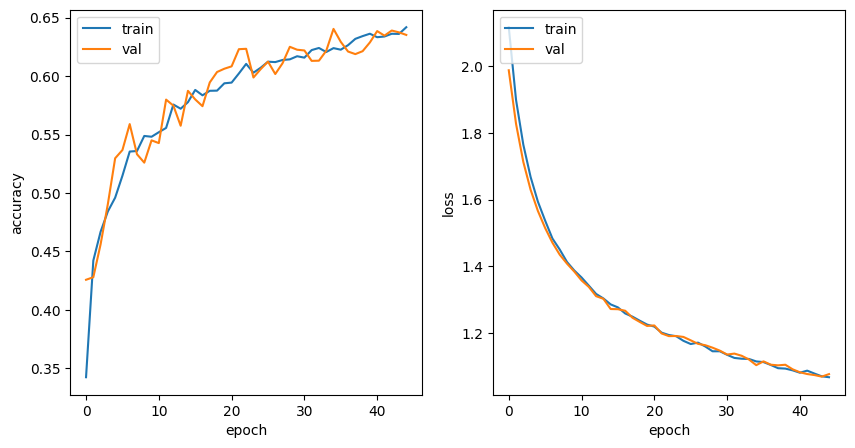

In [19]:
plot_history(history)

In [20]:
model.load_weights('E:/EuroSAT/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator.reset()

predictions = model.predict_generator(test_generator, steps=len(test_generator.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

d:\anaconda3\envs\pastis\lib\site-packages\ipykernel_launcher.py:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Global F2 Score: 0.4348148148148148


d:\anaconda3\envs\pastis\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision,Recall,F-Score,Support
AnnualCrop,0.184539,0.986667,0.310924,900.0
Forest,0.000000,0.000000,0.000000,900.0
HerbaceousVegetation,0.725038,0.524444,0.608640,900.0
Highway,0.882353,0.140000,0.241657,750.0
Industrial,0.780190,0.766667,0.773369,750.0
Pasture,0.000000,0.000000,0.000000,600.0
PermanentCrop,0.846154,0.205333,0.330472,750.0
Residential,0.757231,0.814444,0.784797,900.0
River,0.775510,0.152000,0.254181,750.0
SeaLake,0.993802,0.534444,0.695087,900.0


In [21]:
model = compile_model(INPUT_SHAPE, NUM_CLASSES, optim, fine_tune=14)

train_generator.reset()
valid_generator.reset()

history = model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint],
                             validation_data=valid_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100


d:\anaconda3\envs\pastis\lib\site-packages\ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


118/118 [==============================] - ETA: 0s - loss: 1.5601 - categorical_accuracy: 0.4542
Epoch 1: val_categorical_accuracy did not improve from 0.64031
118/118 [==============================] - 28s 188ms/step - loss: 1.5601 - categorical_accuracy: 0.4542 - val_loss: 1.0238 - val_categorical_accuracy: 0.6066
Epoch 2/100
118/118 [==============================] - ETA: 0s - loss: 0.8859 - categorical_accuracy: 0.6888
Epoch 2: val_categorical_accuracy improved from 0.64031 to 0.74781, saving model to E:/EuroSAT/working\model.weights.best.hdf5
118/118 [==============================] - 23s 198ms/step - loss: 0.8859 - categorical_accuracy: 0.6888 - val_loss: 0.6944 - val_categorical_accuracy: 0.7478
Epoch 3/100
118/118 [==============================] - ETA: 0s - loss: 0.6198 - categorical_accuracy: 0.7848
Epoch 3: val_categorical_accuracy improved from 0.74781 to 0.82844, saving model to E:/EuroSAT/working\model.weights.best.hdf5
118/118 [==============================] - 23s 194ms

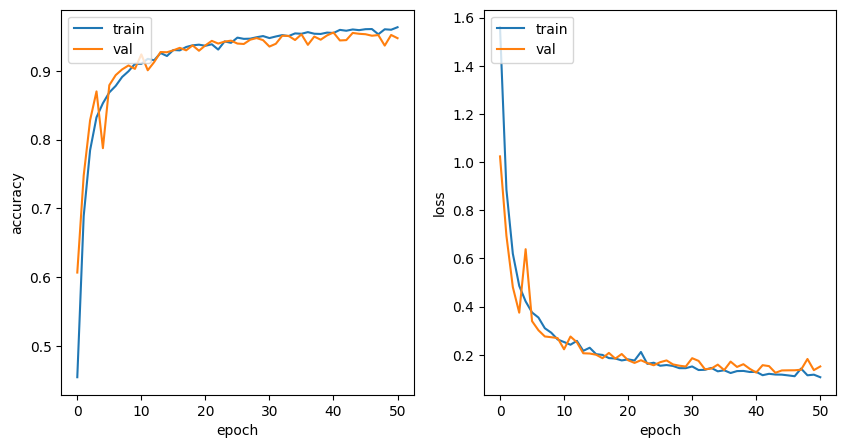

In [22]:
plot_history(history)

In [23]:
model.load_weights('E:/EuroSAT/working/model.weights.best.hdf5')

test_generator.reset()

predictions = model.predict_generator(test_generator, steps=len(test_generator.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator.classes

d:\anaconda3\envs\pastis\lib\site-packages\ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


In [24]:
prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())

Global F2 Score: 0.9585185185185185


In [25]:
prf

,Precision,Recall,F-Score,Support
AnnualCrop,0.946309,0.940000,0.943144,900.0
Forest,0.965293,0.988889,0.976948,900.0
HerbaceousVegetation,0.961582,0.945556,0.953501,900.0
Highway,0.970874,0.933333,0.951734,750.0
Industrial,0.978112,0.953333,0.965564,750.0
Pasture,0.966499,0.961667,0.964077,600.0
PermanentCrop,0.906530,0.944000,0.924886,750.0
Residential,0.930714,1.000000,0.964114,900.0
River,0.968961,0.957333,0.963112,750.0
SeaLake,0.997677,0.954444,0.975582,900.0


In [26]:
conf_mat

,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake
AnnualCrop,846,2,1,4,0,6,39,0,2,0
Forest,1,890,1,0,0,3,0,3,1,1
HerbaceousVegetation,11,8,851,0,0,5,17,7,1,0
Highway,6,0,5,700,8,0,9,8,14,0
Industrial,1,0,0,0,715,0,0,34,0,0
Pasture,2,3,10,1,0,577,7,0,0,0
PermanentCrop,7,0,14,3,4,2,708,12,0,0
Residential,0,0,0,0,0,0,0,900,0,0
River,7,0,2,11,4,3,1,3,718,1
SeaLake,13,19,1,2,0,1,0,0,5,859


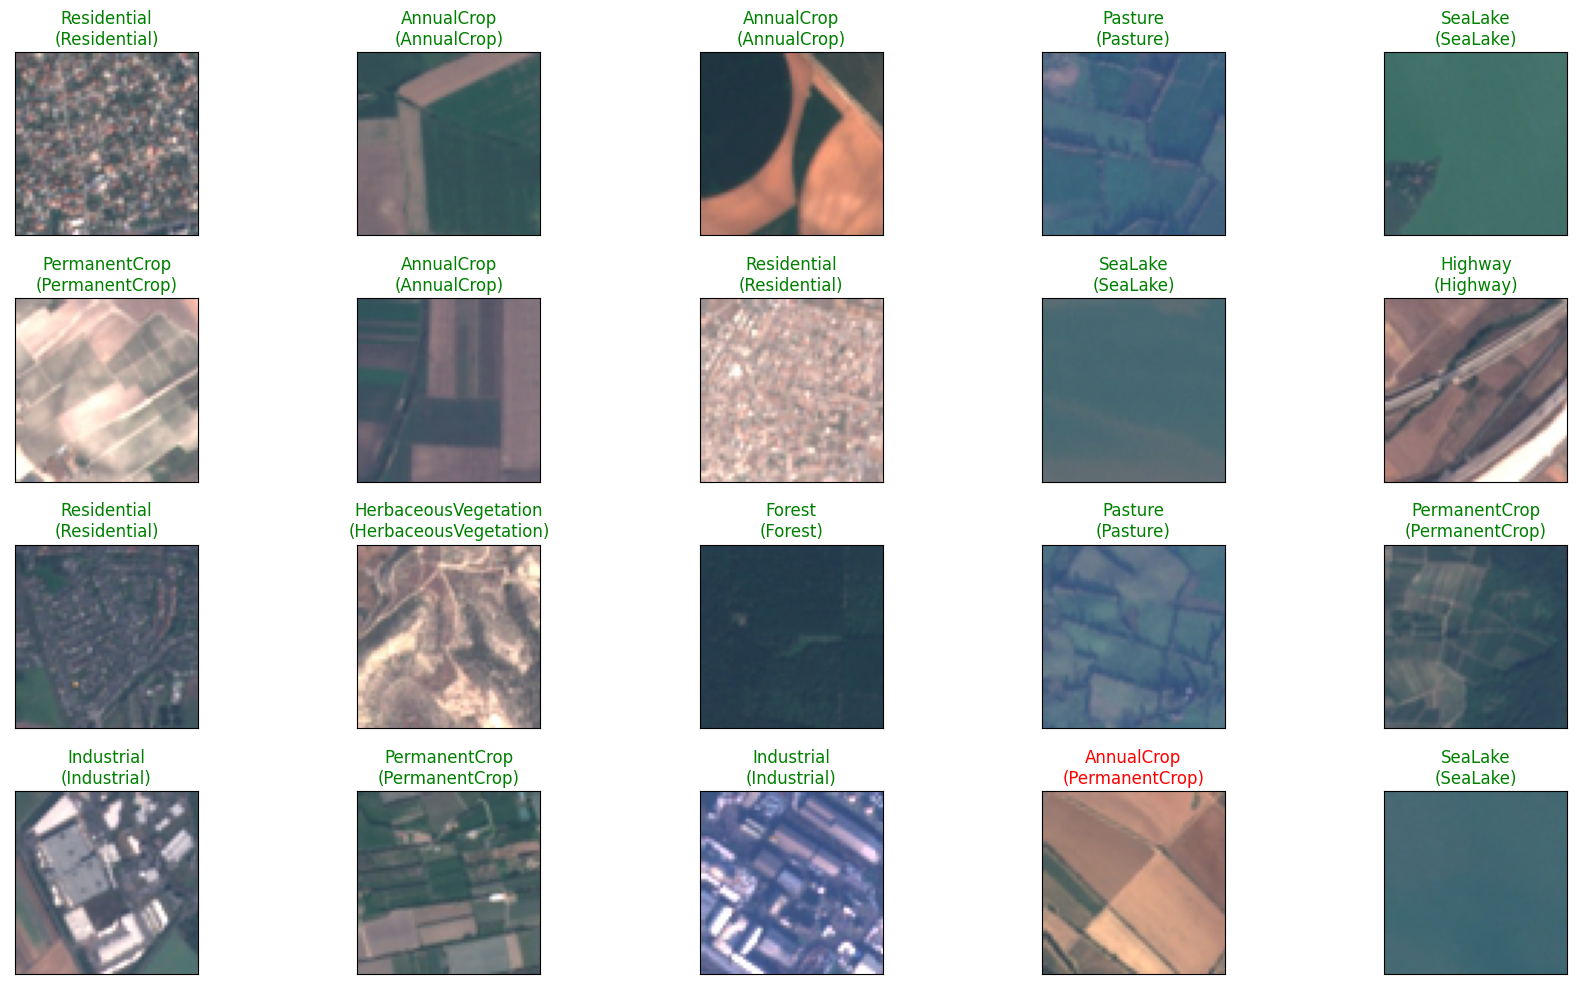

In [27]:
plot_predictions(true_classes, predictions, test_generator, class_indices)

In [28]:
model.save('E:/EuroSAT/working/vgg16_eurosat.h5')

In [1]:
tf.summary.scalar('loss_op', loss_op)

NameError: name 'tf' is not defined